In [1]:
# B3Service

In [2]:

from dataclasses import dataclass, field
from pathlib import Path
from typing import Set, List
import re

import pandas as pd
from riskfolio.src import RiskFunctions


@dataclass
class B3Service:
    """
    B3Service: A service for obtaining B3 tickers from portfolio composition files.

    Args:
    - portfolio_composition_path (Path): The path to the directory containing portfolio composition files.

    Attributes:
    - portfolio_composition_path (Path): The path to the directory containing portfolio composition files.
    """

    portfolio_composition_path: Path
    tickers: Set[str] = field(default_factory=set)

    def _is_valid_ticker(self, ticker: str) -> bool:
        """
        Checks if a ticker is valid.

        Args:
        - ticker (str): Ticker to be validated.

        Returns:
        - bool: True if the ticker is valid, False otherwise.
        """
        return bool(re.match(r"^[A-Z]{4}\d{1,2}$", ticker))

    def _read_tickers_from_file(self, file: Path) -> pd.Series:
        """
        Reads tickers from a given file.

        Args:
        - file (Path): The file from which tickers need to be read.

        Returns:
        - pd.Series: Series containing tickers.
        """
        return pd.read_csv(
            str(file.absolute()), encoding="iso-8859-1", delimiter=";", index_col=False, usecols=[0]
        ).iloc[:, 0]

    def _update_tickers(self, new_tickers: Set[str]) -> None:
        """
        Updates the set of tickers.

        Args:
        - new_tickers (Set[str]): New tickers to be added.
        """
        self.tickers.update(new_tickers)

    def get_b3_tickers(self) -> Set[str]:
        """
        Gets B3 tickers from portfolio composition files.

        Returns:
        - Set[str]: Set of B3 tickers.
        """
        for file in self.portfolio_composition_path.iterdir():
            if not file.is_file() or file.suffix != ".csv":
                continue

            raw_tickers = self._read_tickers_from_file(file)

            valid_tickers = {ticker for ticker in raw_tickers if self._is_valid_ticker(ticker)}
            self._update_tickers(valid_tickers)

        return self.tickers

    def get_b3_tickers_in_yahoo_format(self) -> List[str]:
        return [f"{ticker}.SA" for i, ticker in enumerate(self.get_b3_tickers()) if i < 20]


In [3]:
portfolio_composition_path = Path("data/B3/portfolio_composition")
b3_service = B3Service(portfolio_composition_path)
b3_tickers = b3_service.get_b3_tickers_in_yahoo_format()

b3_tickers

['QUAL3.SA',
 'PRIO3.SA',
 'LAVV3.SA',
 'PNVL3.SA',
 'CCRO3.SA',
 'GUAR3.SA',
 'FESA4.SA',
 'SIMH3.SA',
 'RAIZ4.SA',
 'CMIN3.SA',
 'JBSS3.SA',
 'ONCO3.SA',
 'SAPR11.SA',
 'GOLL4.SA',
 'PETR4.SA',
 'EGIE3.SA',
 'AESB3.SA',
 'AGRO3.SA',
 'JHSF3.SA',
 'PETZ3.SA']

# PortfolioOptimizer

In [41]:
import numpy as np
import pandas as pd
import yfinance as yf
import warnings
import riskfolio as rp
import matplotlib.pyplot as plt
from pathlib import Path


class AssetAnalysisAI:
    def __init__(self, assets, start, end, portfolio_composition_path):
        self.assets = assets
        self.start = start
        self.end = end
        self.portfolio_composition_path = portfolio_composition_path
        self.data = None
        self.returns = None
        self.risk = None
        self.optimal_portfolios = None

    def download_data(self):
        self.data = yf.download(self.assets, start=self.start, end=self.end)
        self.data = self.data.loc[:, ('Adj Close', slice(None))]
        self.data.columns = self.assets

    def calculate_returns(self):
        self.returns = self.data[self.assets].pct_change().dropna()

    def estimate_mean_variance_portfolio(self, returns, risk_measure='MV', objective='Sharpe', rf=0, hist=True, min_weight=0.01):
        # Step 1: Create constraints for minimum weight
        constraints = pd.DataFrame({
            'Disabled': [False],
            'Type': ['All Assets'],
            'Set': [''],
            'Position': [''],
            'Sign': ['>='],
            'Weight': [min_weight],
            'Type Relative': [''],
            'Relative Set': [''],
            'Relative': [''],
            'Factor': ['']
        })

        # Step 2: Create constraints for asset classes
        asset_classes = pd.DataFrame({'Assets': returns.columns, 'Industry': [''] * len(returns.columns)})
        A, B = rp.assets_constraints(constraints, asset_classes)

        # Step 3: Create the Portfolio object
        port = rp.Portfolio(returns=returns)

        # Step 4: Calculate asset statistics
        method_mu, method_cov = 'hist', 'hist'
        port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

        # Step 5: Set the constraints
        port.ainequality, port.binequality = A, B

        # Step 6: Estimate optimal portfolio
        model = 'Classic'
        w = port.optimization(model=model, rm=risk_measure, obj=objective, rf=rf, hist=hist)

        return w

    def plot_portfolio_composition(self, weights, title, cmap='tab20'):
        ax = rp.plot_pie(w=weights, title=title, others=0.05, nrow=25, cmap=cmap, height=6, width=10, ax=None)

    def calculate_efficient_frontier(self, risk_measure='MV', points=50, rf=0, hist=True):
        port = rp.Portfolio(returns=self.returns)
        model = 'Classic'
        frontier = port.efficient_frontier(model=model, rm=risk_measure, points=points, rf=rf, hist=hist)
        return frontier

    def plot_efficient_frontier(self, w_frontier, cmap='viridis'):
        label = 'Max Risk Adjusted Return Portfolio'
        ax = rp.plot_frontier(w_frontier=w_frontier, mu=self.returns.mean(), cov=self.returns.cov(),
                              returns=self.returns, rm='MV', rf=0, alpha=0.05, cmap=cmap, w=None,
                              label=label, marker='*', s=16, c='r', height=6, width=10, ax=None)

    def calculate_optimal_portfolios(self, risk_measures, model='Classic', objective='Sharpe', rf=0, hist=True):
        port = rp.Portfolio(returns=self.returns)
        w_s = pd.DataFrame([])

        for risk_measure in risk_measures:
            w = port.optimization(model=model, rm=risk_measure, obj=objective, rf=rf, hist=hist)
            w_s = pd.concat([w_s, w], axis=1)

        w_s.columns = risk_measures
        self.optimal_portfolios = w_s
        return w_s

    def plot_comparison_of_weights(self, weights):
        fig, ax = plt.subplots(figsize=(14, 6))
        weights.plot.bar(ax=ax)
        return ax

    def create_constraints(self, asset_classes, constraints):
        A, B = rp.assets_constraints(constraints, asset_classes)
        return A, B

    def optimize_with_constraints(self, A, B, risk_measure='MV', objective='Sharpe', rf=0, hist=True):
        port = rp.Portfolio(returns=self.returns)
        port.ainequality, port.binequality = A, B
        weights = port.optimization(model='Classic', rm=risk_measure, obj=objective, rf=rf, l=0, hist=hist)
        return weights

    def plot_pie_for_asset_classes(self, asset_classes):
        w_classes = pd.concat([asset_classes.set_index('Assets'), self.weights], axis=1)
        w_classes = w_classes.groupby(['Industry']).sum()
        ax = rp.plot_pie(w=w_classes, title='Sharpe Mean Variance', others=0.05, nrow=25,
                         cmap="tab20", height=6, width=10, ax=None)
    
    def calculate_risk(self):
        self.risk = pd.DataFrame()
        
        for asset in self.assets:
            risk = np.std(self.returns[asset])
            self.risk.at[asset, "Risk"] = risk
            
        min_risk = self.risk["Risk"].min()
        max_risk = self.risk["Risk"].max()
        new_min = 0
        new_max = 100
        
        self.risk["Risk"] = ((self.risk["Risk"] - min_risk) / (max_risk - min_risk)) * (new_max - new_min) + new_min
        

    def select_top_assets(self, risk_measure='MV', objective='Sharpe', rf=0, hist=True, min_weight=0.01):
        # Step 1: Downloading the data
        data = self.download_data()

        # Step 2: Calculate returns
        self.calculate_returns()
        self.calculate_risk()

        # Step 3: Select the top 10 assets based on returns
        top_assets = self.returns.mean().nlargest(10).index

        # Step 4: Estimate Mean Variance Portfolio for the selected assets with a minimum weight constraint
        selected_returns = self.returns[top_assets]
        weights = self.estimate_mean_variance_portfolio(selected_returns, risk_measure, objective, rf, hist, min_weight)

        # Convert index to a regular column
        weights.reset_index(inplace=True)

        # Step 5: Create a DataFrame with top assets, their weights, risk, and returns
        top_assets_data = pd.DataFrame({'Asset': weights['index'], 'Weight': weights.iloc[:, 1]})
        top_assets_data.set_index('Asset', inplace=True)

        # Calculate risk and return for each asset
        port = rp.Portfolio(returns=selected_returns)
        port.assets_stats(method_mu='hist', method_cov='hist', d=0.94)
        
        top_assets_data['Risk'] = 0
        top_assets_data['Return'] = 0
        
        for asset in top_assets_data.index:
            # Calculate risk and update the DataFrame
            risk = self.risk.loc[asset]["Risk"]
            top_assets_data.at[asset, "Risk"] = risk
            
            # Calculate return and update the DataFrame
            return_ = self.returns[asset].sum()
            top_assets_data.at[asset, "Return"] = return_
            
        
        return top_assets_data

    def plot_scatter_portfolio(self, top_assets_data):
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.scatter(top_assets_data['Risk'], top_assets_data['Return'], alpha=0.8)
        ax.set_title('Risk-Return Scatter Plot')
        ax.set_xlabel('Risk')
        ax.set_ylabel('Return')

        for i, txt in enumerate(top_assets_data.index):
            ax.annotate(txt, (top_assets_data['Risk'][i], top_assets_data['Return'][i]))

        plt.show()



In [42]:
from datetime import datetime

start_date = '2017-01-01'
end_date = datetime.now().strftime('%Y-%m-%d')

portfolio_path = Path("data/B3/portfolio_composition")
b3_service = B3Service(portfolio_path)
assets = b3_service.get_b3_tickers_in_yahoo_format()

# Initialize the AssetAnalysisAI class
asset_analysis = AssetAnalysisAI(assets, start_date, end_date, portfolio_path)

# Use the new method to select the top assets
top_assets_weights = asset_analysis.select_top_assets(min_weight=0.05)

print("Top 10 Assets and their Weights:")
top_assets_weights

[*********************100%%**********************]  20 of 20 completed
Top 10 Assets and their Weights:


/tmp/ipykernel_761912/1296058114.py:27: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  self.returns = self.data[self.assets].pct_change().dropna()
/tmp/ipykernel_761912/1296058114.py:159: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '36.883202857630124' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  top_assets_data.at[asset, "Risk"] = risk
/tmp/ipykernel_761912/1296058114.py:163: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1.4677628919762653' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  top_assets_data.at[asset, "Return"] = return_


,Weight,Risk,Return
Asset,,,
SAPR11.SA,0.438718,36.883203,1.467763
EGIE3.SA,0.050000,54.508588,1.082701
PNVL3.SA,0.050000,49.732471,0.715118
JHSF3.SA,0.161282,16.866447,0.668053
JBSS3.SA,0.050000,47.163368,0.633954
PRIO3.SA,0.050000,27.585695,0.360635
LAVV3.SA,0.050000,24.552731,0.297039
CCRO3.SA,0.050000,0.000000,0.234640
GUAR3.SA,0.050000,43.928352,0.152695


<Axes: xlabel='Asset'>

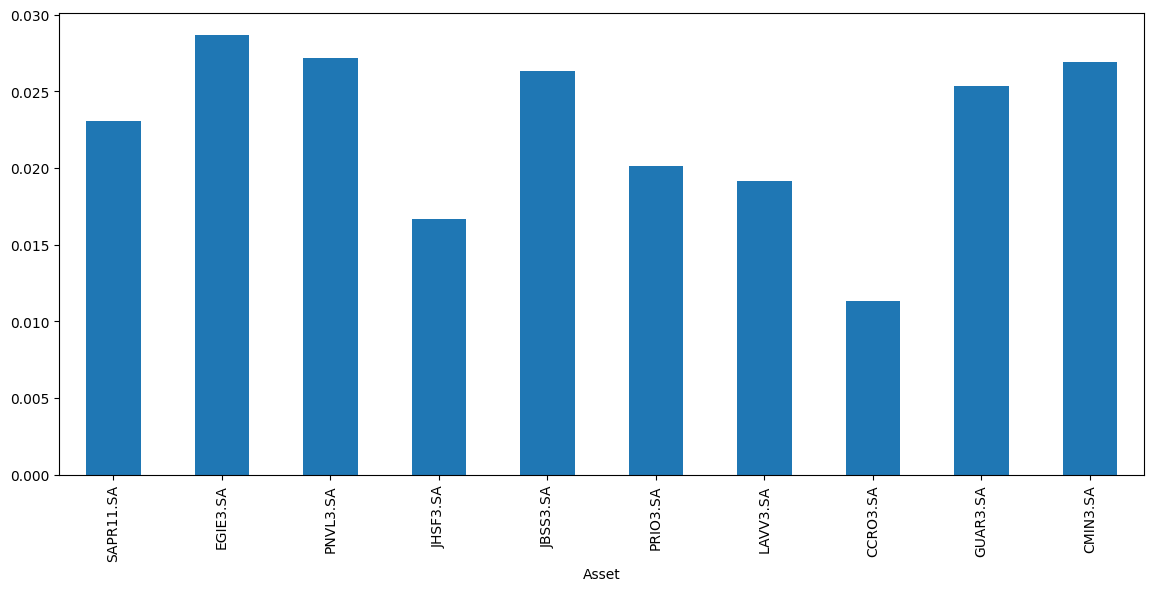

In [13]:
asset_analysis.plot_comparison_of_weights(top_assets_weights.iloc[:,1])

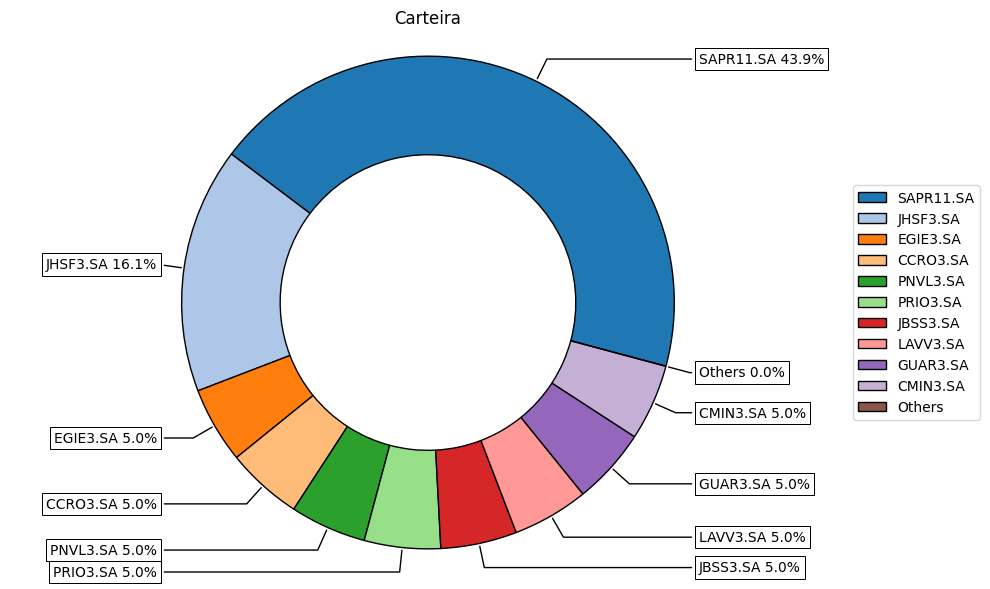

In [23]:
asset_analysis.plot_portfolio_composition(top_assets_weights.Weight.to_frame(), "Carteira")

/tmp/ipykernel_761912/1296058114.py:176: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.annotate(txt, (top_assets_data['Risk'][i], top_assets_data['Return'][i]))


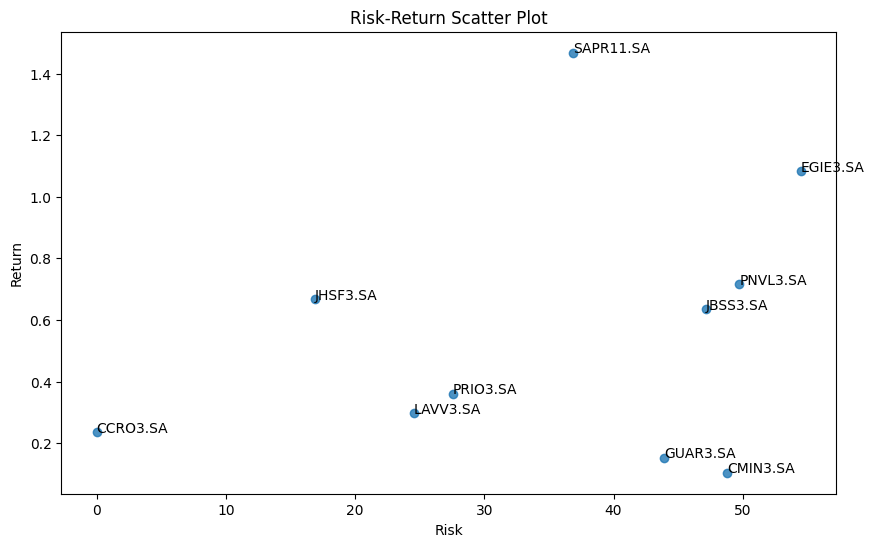

In [43]:
asset_analysis.plot_scatter_portfolio(top_assets_weights)

In [44]:
from selenium.webdriver import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.wait import WebDriverWait
from utils import get_tickers_from_market_index
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from prophet import Prophet
from selenium.webdriver.support import expected_conditions as EC
from selenium import webdriver
import time
import warnings
from typing import Dict


class GordonModel:
    DIVIDEND_DF_FILE = Path("./assets/idiv_companies_dividends.csv")

    def __init__(self, tickers):
        warnings.filterwarnings("ignore", category=DeprecationWarning)
        warnings.filterwarnings("ignore", category=FutureWarning)
        self.tickers = [ticker if ticker.endswith(".SA") else f"{ticker}.SA" for ticker in tickers]
        self.yahoo_dividend_df = self._load_dividend_df()

        self.total_dividend_df = self._calculate_total_dividends()
        self.remove_outliers_from_dividends()

        self.dividend_classification_model = None
        self.dividend_scaler = None
        self.classification: Dict[int, float] = {}
        self.classified_tickers = []

        self.dividend_prediction_models = []

    def _load_dividend_df(self) -> pd.DataFrame:
        if not self.DIVIDEND_DF_FILE.exists():
            self.retrieve_tickers_dividend_data()

        yahoo_dividend_df = pd.read_csv(self.DIVIDEND_DF_FILE)
        yahoo_dividend_df.set_index("Date", inplace=True)
        return yahoo_dividend_df

    def retrieve_tickers_dividend_data(self) -> pd.DataFrame:
        if not self.yahoo_dividend_df:
            self.yahoo_dividend_df = pd.DataFrame()

        tickers_data = yf.Tickers(self.tickers).tickers
        yahoo_dividend_dfs = []

        for ticker, data in tickers_data.items():
            per_month_df = data.actions.groupby(pd.Grouper(freq="M")).sum()
            dividend_df = per_month_df.iloc[:, 0].to_frame()
            dividend_df.rename(columns={'Dividends': ticker}, inplace=True)
            yahoo_dividend_dfs.append(dividend_df)

        self.yahoo_dividend_df = pd.concat(yahoo_dividend_dfs, axis=1, sort=True).fillna(0)
        self.yahoo_dividend_df.index = pd.to_datetime(self.yahoo_dividend_df.index)

        self.yahoo_dividend_df.to_csv(self.DIVIDEND_DF_FILE)

        return self.yahoo_dividend_df

    def _calculate_total_dividends(self) -> pd.DataFrame:
        return self.yahoo_dividend_df.sum().to_frame("Dividend")

    def remove_outliers_from_dividends(self) -> pd.DataFrame:
        mean = np.mean(self.total_dividend_df["Dividend"])
        std_dev = np.std(self.total_dividend_df["Dividend"])

        lower_fence = mean - 1.5 * std_dev
        upper_fence = mean + 1.5 * std_dev

        outliers = self.total_dividend_df[
            (self.total_dividend_df["Dividend"] < lower_fence) | (self.total_dividend_df["Dividend"] > upper_fence)]

        self.total_dividend_df["Dividend"].drop(outliers.index, inplace=True)
        self.total_dividend_df.sort_values(by="Dividend", inplace=True)
        return self.total_dividend_df["Dividend"]

    def classify_dividends(self) -> pd.DataFrame:
        self.dividend_scaler = StandardScaler()
        total_dividend_scaled = self.dividend_scaler.fit_transform(self.total_dividend_df.to_numpy())

        self.dividend_classification_model = KMeans(n_clusters=3, random_state=0)
        self.dividend_classification_model.fit(total_dividend_scaled)

        centers = self.dividend_classification_model.cluster_centers_
        centers = self.dividend_scaler.inverse_transform(centers).ravel()
        labels = self.dividend_classification_model.labels_
        self.classification = {
            classification: centers[classification]
            for classification in np.unique(np.array(labels)).tolist()
        }

        classification = np.column_stack((self.total_dividend_df, labels))
        classification_df = pd.DataFrame(classification, columns=["Dividend", "Classification"])

        tickers_index = self.total_dividend_df.index
        self.total_dividend_df = pd.merge(self.total_dividend_df, classification_df, on="Dividend", how="left")
        self.total_dividend_df.index = tickers_index
        self.total_dividend_df.sort_values(by="Dividend", ascending=True)

        return self.total_dividend_df

    def _classify_tickers(self):
        possible_classification = len(self.classification.keys())
        self.classified_tickers = [[""]] * possible_classification

        for i in range(possible_classification):
            filtered_df = self.total_dividend_df[self.total_dividend_df["Classification"] == i]
            self.classified_tickers[i] = filtered_df.index.to_list()

        return self.classified_tickers

    def _calculate_cap_per_cluster(self) -> Dict[int, float]:
        possible_classification = len(self.classification.keys())
        cap_per_cluster = {
            classification: 0.0
            for classification in range(possible_classification)
        }

        self.yahoo_dividend_df.index = pd.to_datetime(self.yahoo_dividend_df.index, utc=True)
        total_dividend_df_by_year = self.yahoo_dividend_df.groupby(by=pd.Grouper(freq="Y")).sum()

        self._classify_tickers()
        for classification, cluster in enumerate(self.classified_tickers):
            cluster_mean_cap = []

            for ticker in cluster:
                ticker_dividend_history_df = total_dividend_df_by_year[ticker]

                ticker_dividend_history_df = ticker_dividend_history_df.pct_change()
                ticker_dividend_history_df = ticker_dividend_history_df.replace([np.inf, -np.inf], pd.NaT).dropna()
                median_dividend = ticker_dividend_history_df.median()
                cluster_mean_cap.append(median_dividend)

            cap_per_cluster[classification] = np.mean(cluster_mean_cap)

        return cap_per_cluster

    def train_dividend_prediction_models(self) -> None:
        cap_per_cluster = self._calculate_cap_per_cluster()

        for classification in self.classification.keys():
            df = self.yahoo_dividend_df[self.classified_tickers[classification]].mean(axis=1).to_frame()
            df.reset_index(inplace=True)
            df.rename(columns={"Date": "ds", 0: "y"}, inplace=True)
            df["ds"] = pd.to_datetime(df["ds"], utc=True).dt.tz_convert(None)
            df["cap"] = cap_per_cluster[classification]

            ts_model = Prophet()
            ts_model.fit(df)
            self.dividend_prediction_models.append(ts_model)

    def predict_dividend_prediction_models(self, tickers_of_interest: str, plot: bool = False) -> pd.DataFrame:
        tickers_of_interest = tickers_of_interest if tickers_of_interest.endswith(
            ".SA") else f"{tickers_of_interest}.SA"

        ticker_dividend_df = self.yahoo_dividend_df[tickers_of_interest].to_frame()
        ticker_total_dividend = ticker_dividend_df[tickers_of_interest].to_numpy().sum()

        classification = self.dividend_classification_model.predict(
            self.dividend_scaler.transform(ticker_total_dividend.reshape(-1, 1)))[0]

        ticker_dividend_df.reset_index(inplace=True)
        ticker_dividend_df.rename(columns={"Date": "ds", tickers_of_interest: "y"}, inplace=True)
        ticker_dividend_df["ds"] = pd.to_datetime(ticker_dividend_df["ds"], utc=True).dt.tz_convert(None)

        dividend_prediction_model = self.dividend_prediction_models[classification]
        future = dividend_prediction_model.make_future_dataframe(periods=12, freq="M")
        forecast = dividend_prediction_model.predict(future)
        if plot:
            dividend_prediction_model.plot(forecast)

        # Substituir os dividendos com valores negativos por 0
        forecast.loc[forecast["yhat"] < 0, "yhat"] = 0
        forecast = forecast[["ds", "yhat"]]
        forecast.rename(columns={"ds": "Date", "yhat": tickers_of_interest}, inplace=True)

        return forecast

    def _get_data_from_status_invest(self, ticker_of_interest: str):
        driver = webdriver.Chrome()
        driver.get(f"https://statusinvest.com.br/acoes/{ticker_of_interest.replace('.SA', '')}")

        roic_button = WebDriverWait(driver, 5).until(
            EC.presence_of_element_located(
                (By.XPATH, r'//*[@id="indicators-section"]/div[2]/div/div[4]/div/div[3]/div/div/div/button'))
        )
        time.sleep(2)
        roic_button.click()

        average_roic_element = WebDriverWait(driver, 5).until(
            EC.presence_of_element_located(
                (By.XPATH, r'//*[@id="main-modal"]/div[2]/div[1]/div/div[1]/div/div[1]/strong'))
        )
        average_roic = parse(average_roic_element.text)

        currant_roic_element = WebDriverWait(driver, 5).until(
            EC.presence_of_element_located(
                (By.XPATH, r'//*[@id="main-modal"]/div[2]/div[1]/div/div[1]/div/div[2]/strong'))
        )
        currant_roic = parse(currant_roic_element.text)

        exit_roic_menu_button = WebDriverWait(driver, 5).until(
            EC.presence_of_element_located((By.XPATH, r'//*[@id="main-modal"]/div[1]/button'))
        )
        time.sleep(2)
        exit_roic_menu_button.click()

        ev_element = WebDriverWait(driver, 5).until(
            EC.presence_of_element_located(
                (By.XPATH, r'/html/body/main/div[5]/div[1]/div/div[2]/div[8]/div/div/strong'))
        )
        ev = parse(ev_element.text)

        number_of_shares_element = WebDriverWait(driver, 5).until(
            EC.presence_of_element_located(
                (By.XPATH, r'/html/body/main/div[5]/div[1]/div/div[2]/div[9]/div/div/strong'))
        )
        number_of_shares = parse(number_of_shares_element.text)

        driver.quit()

        return average_roic, currant_roic, ev, number_of_shares

    def get_classification_legend(self):
        labels = ["Baixo", "Moderado", "Alto"]

        uniques = self.total_dividend_df["Classification"].unique().tolist()
        dividends = {}

        for classification_unique in uniques:
            dividend = self.total_dividend_df[self.total_dividend_df["Classification"] == classification_unique].iloc[
                0, 0]
            dividends.update({classification_unique: dividend})
        dividends = {key: value for key, value in sorted(dividends.items(), key=lambda item: item[1])}

        return {classification: labels[i] for i, classification in enumerate(dividends.keys())}

    def get_classification_label_for(self, tickers_of_interest: str):
        legend = self.get_classification_legend()
        classification = self.total_dividend_df[self.total_dividend_df.index == tickers_of_interest].iloc[0, -1]

        return legend[classification]

    def _get_roic(self, tickers_of_interest: str, currant_roic: float, average_roic: float):
        return currant_roic if self.get_classification_label_for(tickers_of_interest) == "Moderado" else average_roic

    def calculate_intrinsic_value(self, ticker_of_interest: str, ticker_forecast: pd.DataFrame):
        ticker_of_interest = ticker_of_interest if ticker_of_interest.endswith(".SA") else f"{ticker_of_interest}.SA"

        forecast_pcr_change = ticker_forecast.set_index("Date")
        forecast_pcr_change = forecast_pcr_change.groupby(by=pd.Grouper(freq="Y")).sum()
        forecast_pcr_change = forecast_pcr_change.pct_change()
        forecast_pcr_change.dropna(inplace=True)

        average_roic, currant_roic, ev, number_of_shares = self._get_data_from_status_invest(ticker_of_interest)
        roic = self._get_roic(ticker_of_interest, currant_roic, average_roic)

        iv = abs(ticker_forecast.iloc[-12:, 1].sum() / (roic / 100 - np.median(forecast_pcr_change)))
        iv_reference = ev / number_of_shares

        if iv_reference * 0.8 <= iv <= iv_reference * 1.2:
            return iv

        # roic based on classification is outlier
        alternative_roic = average_roic if roic == currant_roic else currant_roic
        alternative_iv = abs(
            ticker_forecast.iloc[-12:, 1].sum() / (alternative_roic / 100 - np.median(forecast_pcr_change)))

        if iv_reference * 0.8 <= alternative_iv <= iv_reference * 1.2:
            return alternative_iv

        # Gordon Model is not applicable to this ticker
        return iv_reference, iv, alternative_iv


def parse(raw_text: str) -> float:
    return float(raw_text.split()[0].replace(".", "").replace(",", ".").replace("%", ""))


In [45]:
model = GordonModel(b3_tickers)

model.yahoo_dividend_df

,ARZZ3.SA,BRAP4.SA,CVCB3.SA,HAPV3.SA,TIMS3.SA,BLAU3.SA,ENGI11.SA,PETZ3.SA,RAPT4.SA,VALE3.SA,AGRO3.SA,LREN3.SA,RADL3.SA,MRVE3.SA,CMIN3.SA,FLRY3.SA,DIRR3.SA,CMIG4.SA,BBDC3.SA,ABCB4.SA
Date,,,,,,,,,,,,,,,,,,,,
2004-03-31 00:00:00-03:00,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000
2004-04-30 00:00:00-03:00,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000
2004-05-31 00:00:00-03:00,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000
2004-06-30 00:00:00-03:00,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000
2004-07-31 00:00:00-03:00,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-30 00:00:00-03:00,0.000000,0.000000,0.0,0.0,0.175576,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.179690,0.000000,0.0,0.000000,0.169221,0.00,0.189943,0.017250,0.000
2023-10-31 00:00:00-03:00,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.000000,3.212353,0.000000,0.053139,0.0,0.000000,0.000000,0.00,0.000000,0.017250,0.000
2023-11-30 00:00:00-03:00,1.082697,1.786878,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.765771,0.000000,0.000000,0.000000,0.0,0.248842,0.000000,0.00,0.000000,0.017250,0.000


In [46]:
model.total_dividend_df

,Dividend
PETZ3.SA,0.119021
HAPV3.SA,0.219796
BLAU3.SA,1.520197
RADL3.SA,1.692139
CMIN3.SA,2.166437
CVCB3.SA,2.897678
RAPT4.SA,3.939864
TIMS3.SA,4.585592
LREN3.SA,5.791909
MRVE3.SA,6.559223


In [47]:
model.classify_dividends()

,Dividend,Classification
PETZ3.SA,0.119021,2.0
HAPV3.SA,0.219796,2.0
BLAU3.SA,1.520197,2.0
RADL3.SA,1.692139,2.0
CMIN3.SA,2.166437,2.0
CVCB3.SA,2.897678,2.0
RAPT4.SA,3.939864,2.0
TIMS3.SA,4.585592,2.0
LREN3.SA,5.791909,2.0
MRVE3.SA,6.559223,2.0


In [48]:
model.classification

{0: 11.760833571428572, 1: 36.5294315, 2: 3.308716363636364}

In [49]:
model.train_dividend_prediction_models()

16:47:48 - cmdstanpy - INFO - Chain [1] start processing
16:47:48 - cmdstanpy - INFO - Chain [1] done processing
16:47:48 - cmdstanpy - INFO - Chain [1] start processing
16:47:48 - cmdstanpy - INFO - Chain [1] done processing
16:47:48 - cmdstanpy - INFO - Chain [1] start processing
16:47:48 - cmdstanpy - INFO - Chain [1] done processing


In [50]:
model.classified_tickers

[['FLRY3.SA',
  'BBDC3.SA',
  'ABCB4.SA',
  'CMIG4.SA',
  'ARZZ3.SA',
  'ENGI11.SA',
  'AGRO3.SA'],
 ['BRAP4.SA', 'VALE3.SA'],
 ['PETZ3.SA',
  'HAPV3.SA',
  'BLAU3.SA',
  'RADL3.SA',
  'CMIN3.SA',
  'CVCB3.SA',
  'RAPT4.SA',
  'TIMS3.SA',
  'LREN3.SA',
  'MRVE3.SA',
  'DIRR3.SA']]

,Date,VALE3.SA
0,2004-03-31 03:00:00,0.031791
1,2004-04-30 03:00:00,0.200139
2,2004-05-31 03:00:00,0.000000
3,2004-06-30 03:00:00,0.000000
4,2004-07-31 03:00:00,0.000000
...,...,...
246,2024-09-30 03:00:00,0.827833
247,2024-10-31 03:00:00,0.434491
248,2024-11-30 03:00:00,0.477800
249,2024-12-31 03:00:00,0.644438


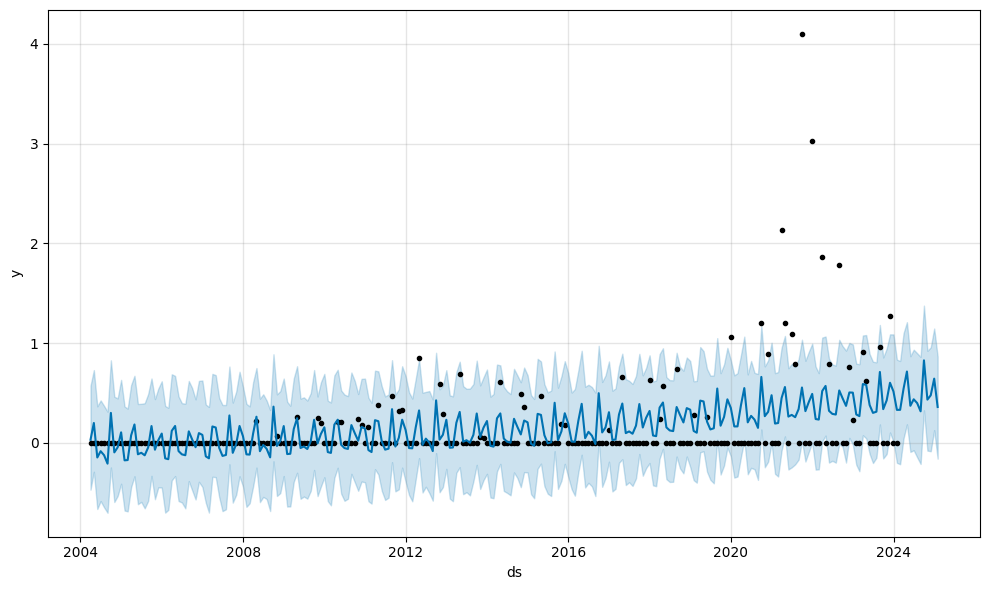

In [51]:
ticker = "VALE3"
vale3_df = model.predict_dividend_prediction_models(ticker, True)
vale3_df

In [52]:
model.calculate_intrinsic_value(ticker, vale3_df)

(79.17228162571168, 256.35861001006907, 61.560528120570474)